# Errors, Norms, and Condition Numbers

(See also section 9.2 of Strang, *Introduction to Linear Algebra*.  The book *Numerical Linear Algebra* by Trefethen and Bau is a good source for a much more in-depth discussion.)

Throughout the semester, when we solve problems like $Ax=b$ on the computer, we notice that the answer is correct "up to roundoff errors" — little errors that appear in the solution, typically $\lesssim 10^{-15}$:

In [1]:
A = randn(5,5)
b = randn(5)
x = A \ b # solve Ax = b
b - A*x # this "residual" should be zero

5-element Array{Float64,1}:
  7.21645e-16
 -3.33067e-16
  7.77156e-16
 -5.55112e-16
 -6.66134e-16

These arise because the computer [only stores about 15 decimal digits](https://en.wikipedia.org/wiki/Floating-point_arithmetic) for each number, so almost every arithmetic operation makes a tiny [round-off error](https://en.wikipedia.org/wiki/Round-off_error).

In real applications, there are lots of other sources of error, too.  If $A$ or $b$ comes from measured data, they probably include [measurement errors](https://en.wikipedia.org/wiki/Observational_error).  Often, the equations you solve on the computer are only approximations for the *real* equations of nature (which may not even be fully known!), so there could also be **systematic errors** or **modelling errors** in your problem.

Such (hopefully) tiny errors are almost inevitable in most real problems. But the key question is **do tiny errors in the *inputs* produce equally tiny errors in the *outputs*,** or **do errors get amplified?**?

## Output error from input error

Suppose that we we want to solve $Ax = b$, but we actually have a *little error Δb in b*.  Does that mean **we have an equally little error in x**?

Let's work it out: we solve $A(x+\Delta x) = b + \Delta b$, and we should obtain
$$
x + \Delta x = A^{-1} (b + \Delta b) = A^{-1} b + A^{-1} \Delta b
$$
so our error should be $\boxed{\Delta x = A^{-1} \Delta b}$.

Let's check:

In [2]:
A = [1    2
     2.01 3.99]
b = [1,2]
x = A \ b # "exact" answer

2-element Array{Float64,1}:
 0.333333
 0.333333

In [3]:
Δb = [-0.01, 0.004]
x′ = A \ (b + Δb)

2-element Array{Float64,1}:
  1.93
 -0.47

In [4]:
x′ - x # the error Δx

2-element Array{Float64,1}:
  1.59667 
 -0.803333

In [5]:
Δx = A \ Δb

2-element Array{Float64,1}:
  1.59667 
 -0.803333

Okay, great, our $\Delta x$ formula worked.  But look at what happened here — we put a "tiny" error $\sim 0.01$ into b, and got a "huge" error $\sim 1$ in x!  Why?

That is, if we compare $\Vert \Delta x \Vert$ to $\Vert \Delta b \Vert$, we get a big increase:

In [6]:
norm(Δb) # the size of the error in the input

0.010770329614269008

In [7]:
norm(Δx) # the size of the error in the output

1.7873692648384276

## Error growth and a matrix norm

In general, what is the relationship between $\Vert \Delta x \Vert$ and $\Vert \Delta b \Vert$?  If $\Delta b$ is a "random" error that could be in *any direction*, how big can $\Vert \Delta x \Vert / \Vert \Delta b \Vert$ be?

That is, we would like to know the **maximum possible value** of
$$
\frac{\Vert \Delta x \Vert}{\Vert \Delta b \Vert} = \frac{\Vert A^{-1} \Delta b \Vert}{\Vert \Delta b \Vert}
$$
over **all possible Δb ≠ 0**.

More generally, for *any* matrix $B$, we define the [induced matrix norm](https://en.wikipedia.org/wiki/Matrix_norm)
$$
\Vert B \Vert = \max_{y\ne 0} \frac{\Vert B y \Vert}{\Vert y \Vert}
$$
This is a measure of "how big" the matrix is, according to the *maximum* amount by which it can "stretch" a vector.

By this definition, $\boxed{\Vert \Delta x \Vert \le \Vert A^{-1} \Vert \; \Vert \Delta b \Vert}$: the **norm of A⁻¹ *bounds* how much the error can increase**.

In Julia, $\Vert B \Vert$ is computed by `norm(B)`, for example:

In [8]:
norm(A)        # ‖A‖

4.996014806077393

In [9]:
norm(inv(A))   # ‖A⁻¹‖

166.53382686925093

The fact that our $A^{-1}$ from above has such a big norm explains why $\Vert \Delta x \Vert$ could be 100× bigger than $\Vert \Delta b \Vert$.

But how can we get $\Vert A^{-1} \Vert$?

One way is to simply compute $\Vert A^{-1} y \Vert / \Vert y \Vert$.  Since $\Vert A^{-1} y \Vert / \Vert y \Vert = \Vert A^{-1} \alpha y \Vert / \Vert \alpha y \Vert$ for any scalar α, we can freely restrict ourselves to $\Vert y \Vert = 1$ (by choosing $\alpha = 1 / \Vert y \Vert$), i.e. we can *equivalently* define

$$
\Vert B \Vert = \max_{\Vert y \Vert = 1} \Vert B y \Vert
$$

So, we can just plot $\Vert A^{-1} y \Vert$ versus angle $\theta$ for $y = (\cos \theta, \sin \theta)$ on the unit circle:

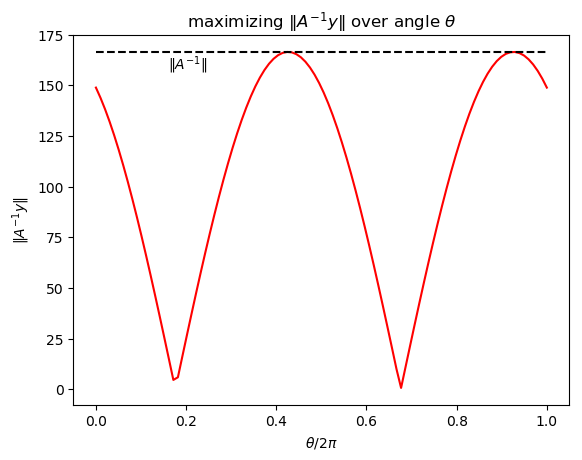

PyObject Text(0.5,1,u'maximizing $\\Vert A^{-1} y \\Vert$ over angle $\\theta$')

In [12]:
using PyPlot
θ = linspace(0,2π,100)
plot(θ/(2π), [norm(A \ [cos(θ), sin(θ)]) for θ in θ], "r-")
plot(θ/(2π), ones(θ)*norm(inv(A)), "k--")
xlabel(L"\theta / 2\pi")
ylabel(L"\Vert A^{-1} y \Vert")
text(0.16,norm(inv(A))*0.95, L"\Vert A^{-1} \Vert")
title(L"maximizing $\Vert A^{-1} y \Vert$ over angle $\theta$")

Yup, the maximum certainly seems to be matching what Julia's `norm` function computes for $\Vert A^{-1} \Vert$.

But there must be a better way to compute it.  Maybe $\Vert A^{-1} \Vert$ is related to $|\lambda|$?

In [13]:
eigvals(inv(A))

2-element Array{Float64,1}:
 -166.533  
    0.20016

In [14]:
abs.(eigvals(inv(A)))

2-element Array{Float64,1}:
 166.533  
   0.20016

Hey, it certainly *looks* like $\Vert A^{-1} \Vert$ is the magnitude of the biggest $\lambda$ of $A^{-1}$.  Let's check it more carefully:

In [15]:
abs.(eigvals(inv(A)))[1] - norm(inv(A))

-0.0003336000409319695

Hmm, this difference of 0.0003 is *much* bigger than the $\sim 10^{-15}$ we normally get from mere roundoff errors.  Let's try another matrix $B$, chosen at random:

In [16]:
B = randn(2,2)
norm(B)

0.9498866099125951

In [17]:
abs.(eigvals(B))

2-element Array{Float64,1}:
 0.842641
 0.842641

Whoops, no, in this case the eigenvalues have *much* smaller magnitudes than $\Vert B \Vert$.  So the near-match in the case of $A^{-1}$ was just a coincidence?

In fact, the right answer involves the **singular values** of the matrix:

In [18]:
svdvals(B)

2-element Array{Float64,1}:
 0.949887
 0.747504

The **norm is the biggest singular value** of the matrix!

In [19]:
svdvals(B)[1] - norm(B)

0.0

In [20]:
svdvals(inv(A))[1] - norm(inv(A))

0.0

(In fact, computing the singular values is precisely how Julia's `norm` function works.)

## The Rayleigh quotient and the min–max theorem

Why is $\Vert B \Vert$ equal to the largest singular value of $B$?  We can derive it!

To avoid square roots, it is convenient to look at $\Vert B \Vert^2$:

$$
\Vert B \Vert^2 = \max_{y\ne 0} \frac{\Vert By \Vert^2}{\Vert y \Vert^2} \\ = \max_{y\ne 0} \frac{(By)^H (By)}{y^H y} = \max_{y\ne 0} \frac{y^H (B^H B) y}{y^H y}
$$

This final ratio is called the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient) of the *Hermitian* matrix $S = B^H B$:
$$
R_S(y) = \frac{y^H S y}{y^H y}
$$

It is a remarkable and important fact, known as the [min–max theorem](https://en.wikipedia.org/wiki/Min-max_theorem) that the *maximum* of the Rayleigh quotient is given by the *biggest λ of S*!

To prove this, since $S$ is an $m\times m$ Hermitian matrix, we use that it's eigenvalues $\lambda_1,\ldots,\lambda_m$ are real and the corresponding eigenvectors $q_1,\ldots,q_m$ can be chosen orthonormality.  Any vector $y$ can be written in this basis as $y = c_1 q_1 + \cdots + c_m q_m$ for some coefficients $c_1,\ldots,c_m$, and then orthonormality means:
$$
R_S(y) = \frac{(c_1 q_1 + \cdots + c_m q_m)^H (\lambda_1 c_1 q_1 + \cdots \lambda_m c_m q_m)}{(c_1 q_1 + \cdots + c_m q_m)^H (c_1 q_1 + \cdots + c_m q_m)} = \frac{\lambda_1 |c_1|^2 + \cdots + \lambda_m |c_m|^2}{ |c_1|^2 + \cdots +  |c_m|^2}
$$
which is just a [weighted average](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean) of the eigenvalues λ.  If we number the eigenvalues in order $\lambda_1 \ge \lambda_2 \ge \cdots \lambda_m$, we immediately get:
$$
R_S(y) = \frac{\lambda_1 |c_1|^2 + \cdots + \lambda_m |c_m|^2}{ |c_1|^2 + \cdots +  |c_m|^2} \le \frac{\lambda_1 |c_1|^2 + \cdots + \lambda_1 |c_m|^2}{ |c_1|^2 + \cdots +  |c_m|^2} = \lambda_1
$$
so $\lambda_1$ is an upper bound, achieved by $R_S(q_1) = \lambda_1$.

So,
$$
\Vert B \Vert = \sqrt{\max\;\lambda\;\mathrm{of}\;B^T B}
$$
Let's check:

In [21]:
norm(B)

0.9498866099125951

In [22]:
sqrt.(eigvals(B'B))

2-element Array{Float64,1}:
 0.747504
 0.949887

But we already learned, in a previous lecture, that the **eigenvalues of BᴴB** are precisely the **the squares σ² of the singular values σ of B**.

In [23]:
svdvals(B)

2-element Array{Float64,1}:
 0.949887
 0.747504

## Key properties of the matrix norm

Note that $\Vert B\Vert$ is defined above for *any* matrix, including non-square matrices.  Some key properties of this norm are:

* Positivity: $\Vert B \Vert \ge 0$, and $= 0$ only if $B = 0$.  (Obvious from the definition and the SVD.)

* Scaling: $\Vert \alpha B \Vert = |\alpha|\;\Vert B \Vert$.  (Obvious from the definition.)

* [Triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality): $\Vert B_1 + B_2 \Vert \le \Vert B_1 \Vert + \Vert B_2 \Vert$.  (Not so obvious, but easy to show from the definition and the triangle inequality for vector norms.)

* Products: $\Vert B_1 B_2 \Vert \le \Vert B_1 \Vert \; \Vert B_2 \Vert$.  (Not so obvious, but easy to show from the definition above.)

It's easy to try some of these:

In [24]:
norm(10*B) / norm(B)

9.999999999999996

In [25]:
B₂ = randn(size(B))
norm(B + B₂) / (norm(B) + norm(B₂))

0.7022689744366356

In [26]:
norm(B * B₂) / (norm(B) * norm(B₂))

0.8070017721511517

### Norm of the inverse

One thing to be careful of is the inverse.  Even $A$ is invertible, $\Vert A \Vert^{-1} \ne \Vert A^{-1} \Vert$ in general!   However, there is a cute trick to get $A^{-1}$.  Let's look at the definition:

$$
\Vert A^{-1} \Vert = \max_{y\ne 0} \frac{\Vert A^{-1} y \Vert}{\Vert y \Vert} = \max_{z\ne 0} \frac{\Vert z \Vert}{\Vert Az \Vert}
$$

where we have substituted $z = A^{-1} y$, i.e. $y = Az$.   But then

$$
\frac{1}{\Vert A^{-1} \Vert} = \min_{z\ne 0} \frac{\Vert Az \Vert}{\Vert z \Vert}
$$

since the maximum is 1 over the minimum.  But, exactly analogous to the discussion above, $\Vert Az \Vert / \Vert z \Vert$ is has a minimum for the *minimum* singular value of $A$!  So

* $\Vert A^{-1} \Vert$ is the *inverse* of the *minimum* singular value of $A$ (assuming $A$ is invertible) 

Let's check:

In [27]:
norm(inv(A))

166.53382686925093

In [28]:
1 ./ svdvals(A)

2-element Array{Float64,1}:
   0.20016
 166.534  

Yup, they match!

In [29]:
norm(inv(A)) - 1/svdvals(A)[2]

1.0032863428932615e-11

(At least up to roundoff errors.)

## Compared to what?  Relative errors

There is still a problem with our presentation above.   How do we decide whether an error $\Vert \Delta x \Vert$ is big or small?  Compared to what?

Above, we compared to $\Vert \Delta b \Vert$.  But this is often *not* the right thing to do.  We can see that in a couple of ways:

* In a physical system, $x$ and $b$ may have *different units*.  e.g. $b$ may be a current and $x$ may be a voltage.  $\Vert \Delta x \Vert / \Vert \Delta b \Vert$ is therefore a *dimensionful* quantity, and we can't  say whether it is big or small without comparing to some other dimensionful quantity with the same units.

* If we multiply $A$ by 1000, it is easy to see from above that $\Vert A \Vert$ multiples by 1000 and $\Vert A^{-1} \Vert$ is *divided* by 1000.  But simply scaling the problem shouldn't change whether the errors are big or small!  (You can't reduce the errors in your experiment by changing units from meters to millimeters!)

The right thing to do is generally to compare $\Vert \Delta x \Vert$ to $\Vert x \Vert$ and $\Vert \Delta b \Vert$ to $\Vert b \Vert$.   The ratio
$$
\frac{\Vert \Delta x \Vert}{\Vert x \Vert}
$$
is called the [relative error](https://en.wikipedia.org/wiki/Approximation_error), as opposed to the *absolute* error $\Vert \Delta x \Vert$.

### Condition number of a matrix

How much can the relative error grow when we solve $Ax = b$? Well, from above:

$$
\frac{\Vert \Delta x \Vert}{\Vert x \Vert} \le \frac{\Vert A^{-1} \Vert \; \Vert \Delta b \Vert}{\Vert x \Vert} = \frac{\Vert A^{-1} \Vert \; \Vert \Delta b \Vert}{\Vert b \Vert} \frac{\Vert Ax \Vert}{\Vert x \Vert} \le \boxed{\Vert A \Vert \; \Vert A^{-1} \Vert \frac{\Vert \Delta b \Vert}{\Vert b \Vert}}
$$

The quantity $\kappa(A) = \Vert A \Vert \; \Vert A^{-1} \Vert$ is called the [condition number](https://en.wikipedia.org/wiki/Condition_number) of the matrix A.  It gives an **upper bound** on how much the **relative error can grow** when comparing input to output.   Since $\kappa(A) = \kappa(A^{-1})$, it is the same for computing $x = A^{-1} b$ or for computing $b = Ax$ (i.e. x from b or b from x)!   In Julia, it is computed by `cond(A)`.

In [30]:
cond(A)

832.0054647514568

In [31]:
norm(A) * norm(inv(A))

832.0054647515068

From the definition above and the relationship of the matrix norm to the singular values, the **condition number is the ratio of the largest to the smallest singular value** of A:

$$
\boxed{\kappa(A) = \Vert A \Vert \; \Vert A^{-1} \Vert = \frac{\sigma_\max}{\sigma_\min}}
$$

In [32]:
σ = svdvals(A)
maximum(σ) / minimum(σ)

832.0054647514568

From this, we can see that $\kappa(A) \ge 1$.  **The smallest possible condition number is 1**.   This happens for $\kappa(I) = 1$, or for any multiple of $I$, and in fact **any unitary matrix** has condition number 1.

## Ill-conditioned matrices

If the condition number is $\gg 1$, we say that the matrix is **ill-conditioned** (or "badly conditioned").   When you solve an ill-conditioned problem, **any error can be greatly magnified**.  This includes both measurement errors and things like roundoff errors during the calculations.

Our matrix $A$ above pretty badly conditioned — it can magnify erros by a factor of $\sim 1000$:

In [33]:
cond(A)

832.0054647514568

An **ill-conditioned matrix is a matrix that is *almost* singular**.   A singular matrix has a condition number of "∞": the condition number blows up as one of the singular values goes to zero.

It is easy to see that our matrix $A$ from above is almost singular: the second row is *almost* twice the first row:

In [34]:
A

2×2 Array{Float64,2}:
 1.0   2.0 
 2.01  3.99

That's why our error increased by so much:

In [35]:
norm(Δx)/norm(x) / (norm(Δb)/norm(b))

787.184529039192

(In fact, I didn't pick `Δb` at random: I picked it to lie almost parallel to the singular vector for the smallest singular value, to magnify the error as much as possible.)

Just because a matrix is ill-conditioned does not mean that you can't get accurate answers, but it indicates that you need to be **much more careful** about errors.

## Nearly defective matrices

In class, we discussed defective matrices, in which we are "missing" some eigenvectors (due to repeated roots) and hence don't have a basis.  In practice, *exactly* defective matrices are extremely uncommon.

However, it is much more common to have a *nearly* defective matrix $A$, in which two or more eigenvectors are *nearly* parallel.   Such matrices are still diagonalizable, $A = X \Lambda X^{-1}$, so why worry?

The problem with a *nearly* defective matrix is that the eigenvector matrix $X$ is *nearly* singular — it is **ill-conditioned**!  That means that *working with eigenvectors of a nearly-defective matrix is very sensitive to errors (roundoff, measurement, …)*!

For example, let's construct a nearly defective matrix $M$ with eigenvectors $(1,0)$ and $(1,10^{-14})$, and eigenvalues $\lambda = 1$ and $\lambda = 1 + 10^{-14}$.

In [36]:
X = [1  1
     0  1e-14]
M = X * diagm([1,1+1e-14]) / X

2×2 Array{Float64,2}:
 1.0  0.999201
 0.0  1.0     

Now, let's compute the matrix exponential $e^M$, both by the built-in Julia function `expm` and by the 18.06 formula involving the diagonalization $X e^\Lambda X^{-1}$:

In [37]:
expm(M)

2×2 Array{Float64,2}:
 2.71828  2.71611
 0.0      2.71828

In [38]:
X * expm(diagm([1,1+1e-14])) / X

2×2 Array{Float64,2}:
 2.71828  2.57572
 0.0      2.71828

The two don't match very well, and in fact the diagonalization-based formula gives horribly wrong results (off by about 10%).   Computing matrix exponentials (and many other matrix functions) robustly for arbitrary matrices (including nearly defective matrices) is a tricky problem.  There is a famous paper called [Nineteen Dubious Ways to Compute the Exponential of a Matrix](http://epubs.siam.org/doi/abs/10.1137/S00361445024180) on the many possible approaches.

The "opposite" of a nearly defective matrix is a matrix with an *orthonormal* basis $X=Q$ of eigenvectors (e.g. a Hermitian, unitary, or other ["normal"](https://en.wikipedia.org/wiki/Normal_matrix) matrix).   In this case, the eigenvector basis has condition number $= 1$, the best possible conditioning, and working with eigenvectors is great!